In [325]:
import re
import nltk

import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

import warnings 
warnings.filterwarnings('ignore')

In [326]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [327]:
# шаг пакетного обучения
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    losses = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 32 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        losses += loss
        avg_loss = losses / num_batches
    return avg_loss 

# оценка модели на тестовой выборке (акьюраси и ошибка)
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## 1. Представление и предобработка текстовых данных 

1.1 Операции по предобработке:
* токенизация
* стемминг / лемматизация
* удаление стоп-слов
* удаление пунктуации
* приведение к нижнему регистру
* любые другие операции над текстом

In [232]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

In [233]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

Реализовать функцию `preprocess_text(text: str)`, которая:
* приводит строку к нижнему регистру
* заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел



```
text = text.lower()
text = re.sub('[^A-Za-z0-9]+', ' ', text)
text
```



In [234]:
def preprocess_text(text: str):
  text = text.lower()
  text = re.sub('[^a-z.,!?]+', ' ', text)
  return text

In [235]:
preprocess_text(text)

'select your preferences and run the install command. stable represents the most currently tested and supported version of pytorch. note that libtorch is only available for c '

1.2 Представление текстовых данных при помощи бинарного кодирования


Представить первое предложение из `text` в виде тензора `sentence_t`: `sentence_t[i] == 1`, если __слово__ с индексом `i` присуствует в предложении.

In [236]:
prep_text = preprocess_text(text)
words = list(set(nltk.word_tokenize(prep_text)))
words.remove('.')
words_idx = {word: i for i, word in enumerate(words)}
print(words_idx)

sentences = nltk.sent_tokenize(prep_text)
first_sentence = sentences[0].replace('.','')
print(first_sentence)

idxs = []
for word in nltk.word_tokenize(first_sentence):
  idxs.append(words_idx[word])

sentence_t = torch.zeros(len(words))
sentence_t[[idxs]] = 1
sentence_t

{'tested': 0, 'and': 1, 'select': 2, 'the': 3, 'currently': 4, 'your': 5, 'stable': 6, 'supported': 7, 'only': 8, 'version': 9, 'preferences': 10, 'install': 11, 'of': 12, 'that': 13, 'pytorch': 14, 'for': 15, 'run': 16, 'available': 17, 'note': 18, 'most': 19, 'command': 20, 'represents': 21, 'is': 22, 'c': 23, 'libtorch': 24}
select your preferences and run the install command


tensor([0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0.])

## 2. Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`. 

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)

2.5 Реализовать класс `SurnamesDataset`

2.6. Обучить классификатор.

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [237]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [238]:
# 2.1 Считать файл surnames/surnames.csv.
surnames = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/surnames.csv')
surnames.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [239]:
# 2.2 Закодировать национальности числами, начиная с 0.
# супермегатупой способ :)
nat_idxs = {nationality: i for i, nationality in enumerate(surnames['nationality'].unique())}
print(nat_idxs)
surnames['nat_idx'] = 0
for i in range(len(surnames)):
  surnames['nat_idx'][i] = nat_idxs[surnames['nationality'][i]]
surnames.tail()

{'English': 0, 'French': 1, 'Arabic': 2, 'Russian': 3, 'Japanese': 4, 'Chinese': 5, 'Italian': 6, 'Czech': 7, 'Irish': 8, 'German': 9, 'Greek': 10, 'Spanish': 11, 'Polish': 12, 'Dutch': 13, 'Vietnamese': 14, 'Korean': 15, 'Portuguese': 16, 'Scottish': 17}


,surname,nationality,nat_idx
10975,Quraishi,Arabic,2
10976,Innalls,English,0
10977,Król,Polish,12
10978,Purvis,English,0
10979,Messerli,German,9


In [240]:
labeler = LabelEncoder()
surnames['nat_idx'] = labeler.fit_transform(surnames["nationality"])
#nat_idxs = {nationality: i for i, nationality in enumerate(labeler.classes_)}
surnames.tail()

,surname,nationality,nat_idx
10975,Quraishi,Arabic,0
10976,Innalls,English,4
10977,Król,Polish,12
10978,Purvis,English,4
10979,Messerli,German,6


In [241]:
labeler.inverse_transform([9])

array(['Italian'], dtype=object)

In [242]:
# 2.3 Разбить датасет на обучающую и тестовую выборку
X = surnames['surname'].str.lower()
y = surnames['nat_idx']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [243]:
# 2.4 Реализовать класс Vocab (токен = символ)

class Vocab:
  def __init__(self, data):

    # массив из всех букв английского алфавита 
    tokens = []
    for i in range(97, 122):
        tokens.append(chr(i))
    # print(tokens)

    # множество символов встречающихся в датасете
    data_tokens = set(char for word in data for char in word.lower())

    data_tokens.update(tokens)

    self.idx_to_token = dict(enumerate(data_tokens))
    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
    self.vocab_len = len(self.idx_to_token)
  

vocab = Vocab(surnames["surname"])
vocab.vocab_len

55

In [244]:
# 2.5 Реализовать класс SurnamesDataset
class SurnamesDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, surname):
    '''Генерирует представление фамилии surname в при помощи бинарного кодирования (см. 1.2)'''
    idxs = []
    for token in surname.lower():
      idxs.append(vocab.token_to_idx[token])
    surname_t = torch.zeros(vocab.vocab_len)
    surname_t[[idxs]] = 1
    return surname_t

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.vectorize(self.X.iloc[idx]), self.y.iloc[idx]

In [245]:
surname = 'volkova'
idxs = []
for token in surname:
  idxs.append(vocab.token_to_idx[token])

surname_t = torch.zeros(vocab.vocab_len)
surname_t[[idxs]] = 1
surname_t, idxs, vocab.idx_to_token

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
         0.]),
 [16, 49, 53, 17, 49, 16, 50],
 {0: 'q',
  1: 'f',
  2: 'ó',
  3: "'",
  4: 'e',
  5: 'ń',
  6: 'á',
  7: 'y',
  8: 'b',
  9: 'w',
  10: 'é',
  11: 'z',
  12: 't',
  13: 'õ',
  14: 'ß',
  15: 'p',
  16: 'v',
  17: 'k',
  18: 'j',
  19: 'u',
  20: 'ò',
  21: 'ã',
  22: 'ł',
  23: 'r',
  24: 'ü',
  25: 'ù',
  26: 'x',
  27: '-',
  28: '/',
  29: 'à',
  30: 'n',
  31: 'ú',
  32: 'ä',
  33: ':',
  34: 'ż',
  35: 's',
  36: 'í',
  37: 'ç',
  38: 'h',
  39: 'ś',
  40: 'ą',
  41: 'i',
  42: 'm',
  43: 'ö',
  44: 'ì',
  45: 'c',
  46: 'd',
  47: '1',
  48: 'è',
  49: 'o',
  50: 'a',
  51: 'ê',
  52: 'g',
  53: 'l',
  54: 'ñ'})

In [246]:
SurnamesDataset(X_train, y_train, vocab).__getitem__(0), X_train.iloc[0]

((tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
          0.]), 1), 'dan')

In [247]:
# 2.6. Обучить классификатор.

class SurnamesClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super(SurnamesClassifier, self).__init__()
        self.seq = nn.Sequential(
                        nn.Linear(in_features, 300),
                        nn.ReLU(),
                        nn.Linear(300, out_features))
    def forward(self, inputs):
        return self.seq(inputs)

In [248]:
learning_rate = 0.001
batch_size = 128
epochs = 100

model = SurnamesClassifier(vocab.vocab_len, len(labeler.classes_))
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = SurnamesDataset(X_train, y_train, vocab)
test_dataset = SurnamesDataset(X_test, y_test, vocab)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(train_loss)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.891352  [    0/ 8784]
loss: 2.157819  [ 4096/ 8784]
loss: 1.910082  [ 8192/ 8784]
Test Error: 
 Accuracy: 45.9%, Avg loss: 1.922345 

Epoch 2
-------------------------------
loss: 1.967713  [    0/ 8784]
loss: 1.820389  [ 4096/ 8784]
loss: 1.755823  [ 8192/ 8784]
Test Error: 
 Accuracy: 50.5%, Avg loss: 1.678185 

Epoch 3
-------------------------------
loss: 1.722213  [    0/ 8784]
loss: 1.687113  [ 4096/ 8784]
loss: 1.699243  [ 8192/ 8784]
Test Error: 
 Accuracy: 51.8%, Avg loss: 1.579937 

Epoch 4
-------------------------------
loss: 1.563854  [    0/ 8784]
loss: 1.646649  [ 4096/ 8784]
loss: 1.637343  [ 8192/ 8784]
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.498691 

Epoch 5
-------------------------------
loss: 1.437340  [    0/ 8784]
loss: 1.425917  [ 4096/ 8784]
loss: 1.200053  [ 8192/ 8784]
Test Error: 
 Accuracy: 54.5%, Avg loss: 1.458103 

Epoch 6
-------------------------------
loss: 1.162668  [    0/ 8784]
loss: 1.480985  [ 40

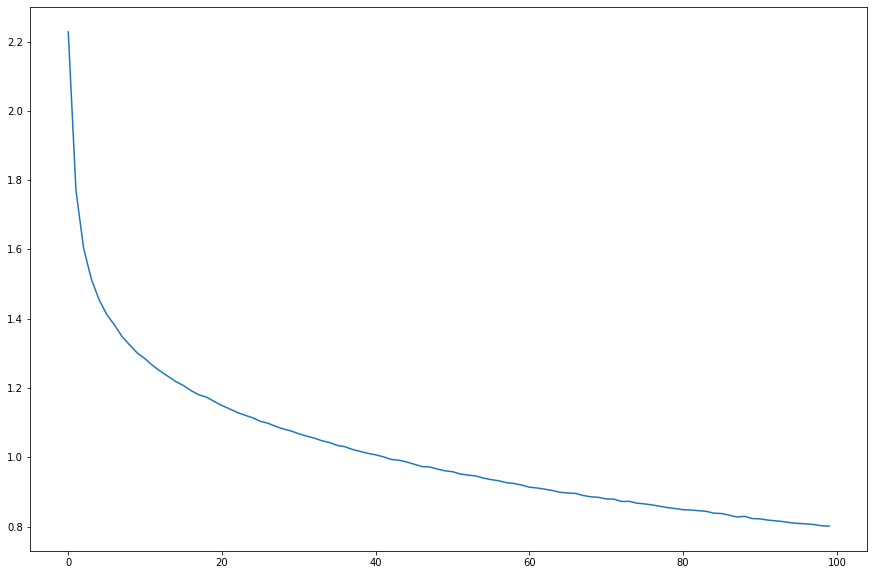

In [249]:
import matplotlib.pyplot as plt

with torch.no_grad():
  plt.plot(losses)

In [255]:
labeler.classes_, labeler.inverse_transform(range(15))

(array(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French',
        'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean',
        'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish',
        'Vietnamese'], dtype=object),
 array(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French',
        'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean',
        'Polish', 'Portuguese', 'Russian'], dtype=object))

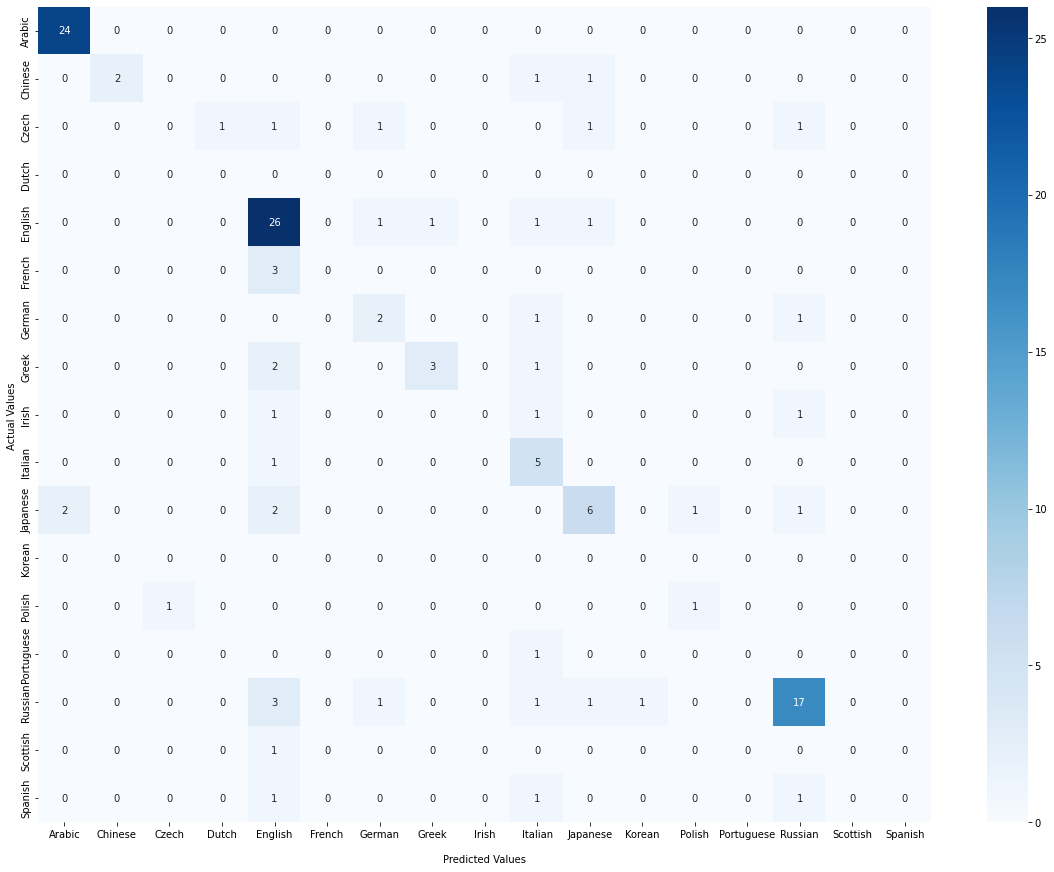

In [259]:
from sklearn.metrics import confusion_matrix

X_test, y_true = next(iter(test_dataloader))
y_pred = model(X_test).argmax(dim=1)

cm = confusion_matrix(y_true, y_pred)

import seaborn as sns

plt.rcParams["figure.figsize"] = (20, 15)

ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(labeler.classes_)
ax.yaxis.set_ticklabels(labeler.classes_)

plt.show()

In [251]:
# 2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 64.9%, Avg loss: 1.174021 



In [252]:
surname = 'Volkova'
x = train_dataset.vectorize(surname)
predictions = model(x)
print(predictions, '\nmost likely you are -> ', labeler.inverse_transform([predictions.argmax()])[0])

tensor([-15.9034,  -9.5946,   3.4422,  -0.0456,  -0.3125,  -6.0801,  -1.1140,
         -0.7082,  -3.9002,  -6.9162, -15.4982, -12.4553,  -1.7702,  -6.4027,
          3.2525,  -4.7399,  -5.6805,  -9.5561], grad_fn=<AddBackward0>) 
most likely you are ->  Czech


In [253]:
labeler.inverse_transform(np.argsort(predictions.detach().numpy())[-3:])

array(['Dutch', 'Russian', 'Czech'], dtype=object)

In [262]:
surname = 'Kotova'
x = train_dataset.vectorize(surname)
predictions = model(x)
labeler.inverse_transform(np.argsort(predictions.detach().numpy())[-3:])

array(['German', 'Czech', 'Russian'], dtype=object)

In [263]:
surname = 'Sokolova'
x = train_dataset.vectorize(surname)
predictions = model(x)
labeler.inverse_transform(np.argsort(predictions.detach().numpy())[-3:])

array(['Czech', 'Greek', 'Russian'], dtype=object)

In [260]:
surname = 'Badmaev'
x = train_dataset.vectorize(surname)
predictions = model(x)
labeler.inverse_transform(np.argsort(predictions.detach().numpy())[-3:])

array(['Spanish', 'English', 'Russian'], dtype=object)

In [261]:
surname = 'Bedak'
x = train_dataset.vectorize(surname)
predictions = model(x)
labeler.inverse_transform(np.argsort(predictions.detach().numpy())[-3:])

array(['Arabic', 'Japanese', 'English'], dtype=object)

## 3. Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g

3.1 Считать файл `yelp/raw_train.csv`. Оставить от исходного датасета 10% строчек.

3.2 Воспользоваться функцией `preprocess_text` из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

3.3 Разбить датасет на обучающую и тестовую выборку

3.4 Реализовать класс `Vocab` (токен = слово)

3.5 Реализовать класс `ReviewDataset`

3.6 Обучить классификатор

3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)


In [328]:
# 3.1 Считать файл yelp/raw_train.csv. Оставить от исходного датасета 10% строчек.

reviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/raw_train.csv', header=None, names=['rating', 'review'])
reviews.tail()

,rating,review
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...
559999,2,Ryan Rocks! I called him this morning for some...


In [329]:
reviews = reviews.sample(frac=0.1, ignore_index=True, random_state=1)
reviews.tail()

,rating,review
55995,1,Stratosphere just doesn't capture the Vegas ex...
55996,2,"There will always be the image 2007, where one..."
55997,1,Arrogance and attitude do not make a good busi...
55998,2,I'm not sure I've ever been to a place where p...
55999,1,Ordered a large pizza as a take out. It looke...


In [330]:
# 3.2 Воспользоваться функцией preprocess_text из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

reviews['review'] = reviews['review'].apply(lambda text: preprocess_text(text))
reviews['rating'] = labeler.fit_transform(reviews['rating'])
reviews.head()

,rating,review
0,1,"omg, the grandma g s pizza with rosemary chick..."
1,0,microwaved food over over over seasoned gyro m...
2,0,"while the food is good, the service leaves a l..."
3,0,called the chandler pd about the sign spinner ...
4,1,"just took ewok, my approx. month old shih tzu ..."


In [331]:
reviews['rating'].unique() 

array([1, 0])

In [332]:
# 3.3 Разбить датасет на обучающую и тестовую выборку

X = reviews['review']
y = reviews['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [333]:
len(X_train), len(X_test)

(44800, 11200)

In [334]:
# 3.4 Реализовать класс Vocab (токен = слово)

class Vocab:
  def __init__(self, data):
    self.idx_to_token = dict(enumerate(set(word for text in data for word in nltk.word_tokenize(text))))
    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
    self.vocab_len = len(self.idx_to_token)
  

vocab = Vocab(reviews["review"])
vocab.vocab_len

72594

In [335]:
# 3.5 Реализовать класс ReviewDataset
class ReviewDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, review):
    '''Генерирует представление отзыва review при помощи бинарного кодирования (см. 1.2)'''
    idxs = []
    for token in nltk.word_tokenize(review):
      idxs.append(vocab.token_to_idx[token])
    review_t = torch.zeros(self.vocab.vocab_len)
    review_t[[idxs]] = 1
    return review_t

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.vectorize(self.X.iloc[idx]), self.y.iloc[idx]

In [336]:
ReviewDataset(X_train, y_train, vocab).__getitem__(0), X_train.iloc[0]

((tensor([0., 0., 0.,  ..., 0., 0., 0.]), 1),
 'this place was so cool looking! real dark with a moder futuristic type feel with glowing blue lamps and crazy shaped decorations on the wall. the deluxe burger was great and you get french fries in this little shopping car. we got the sweet potato regular fries... great! they even serve it with fancy sauce step brothers reference.. but true story !')

In [337]:
# 3.6 Обучить классификатор

class ReviewsClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super(ReviewsClassifier, self).__init__()
        self.seq = nn.Sequential(
                        nn.Linear(in_features, 300),
                        nn.ReLU(),
                        nn.Dropout(),
                        nn.Linear(300, out_features))
    def forward(self, inputs):
        return self.seq(inputs)

In [338]:
learning_rate = 0.001
batch_size = 128
epochs = 5

model = ReviewsClassifier(vocab.vocab_len, len(labeler.classes_))
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = ReviewDataset(X_train, y_train, vocab)
test_dataset = ReviewDataset(X_test, y_test, vocab)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(train_loss)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 0.692641  [    0/44800]
loss: 0.398405  [ 4096/44800]
loss: 0.206525  [ 8192/44800]
loss: 0.275411  [12288/44800]
loss: 0.130599  [16384/44800]
loss: 0.241259  [20480/44800]
loss: 0.168546  [24576/44800]
loss: 0.243699  [28672/44800]
loss: 0.253460  [32768/44800]
loss: 0.250397  [36864/44800]
loss: 0.178263  [40960/44800]
Test Error: 
 Accuracy: 91.3%, Avg loss: 0.214014 

Epoch 2
-------------------------------
loss: 0.125156  [    0/44800]
loss: 0.118849  [ 4096/44800]
loss: 0.175637  [ 8192/44800]
loss: 0.148124  [12288/44800]
loss: 0.119068  [16384/44800]
loss: 0.111553  [20480/44800]
loss: 0.124462  [24576/44800]
loss: 0.147986  [28672/44800]
loss: 0.155700  [32768/44800]
loss: 0.166718  [36864/44800]
loss: 0.116093  [40960/44800]
Test Error: 
 Accuracy: 91.9%, Avg loss: 0.210194 

Epoch 3
-------------------------------
loss: 0.085943  [    0/44800]
loss: 0.038656  [ 4096/44800]
loss: 0.150084  [ 8192/44800]
loss: 0.074053  [12288/448

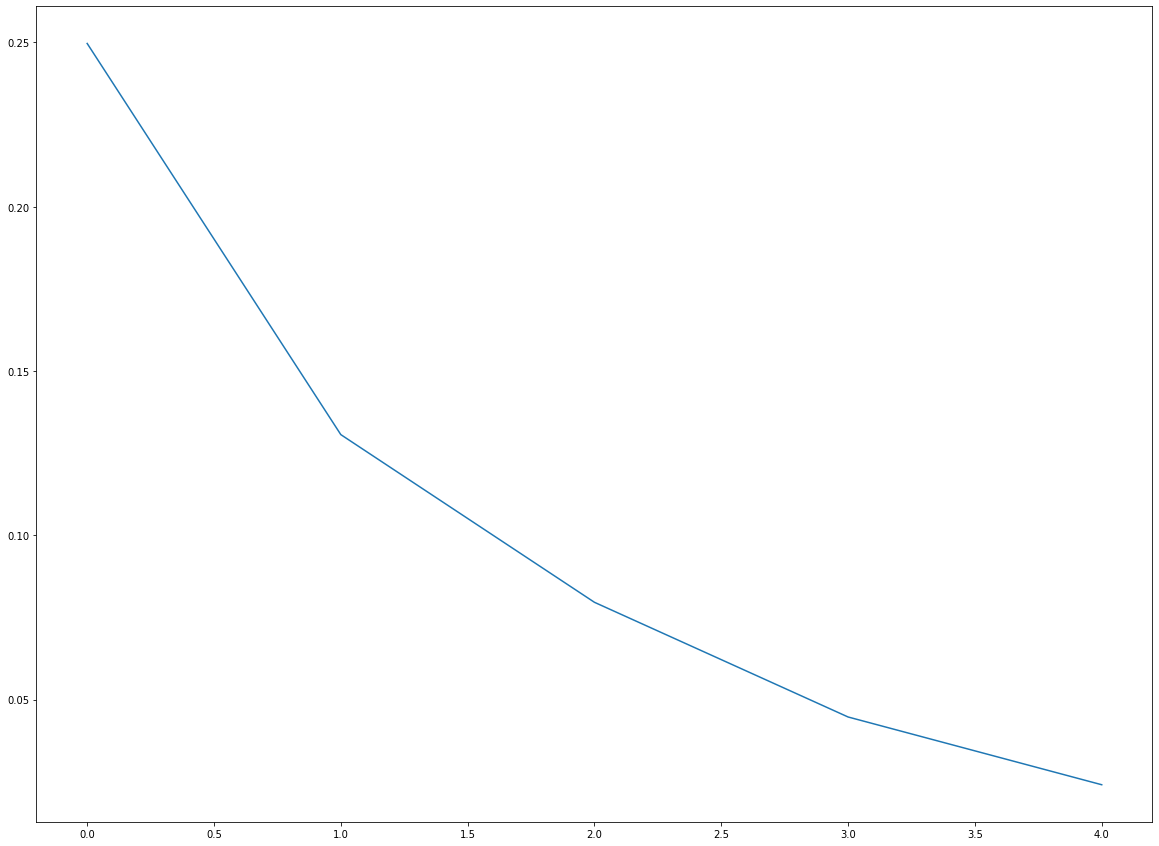

In [339]:
import matplotlib.pyplot as plt

with torch.no_grad():
  plt.plot(losses)

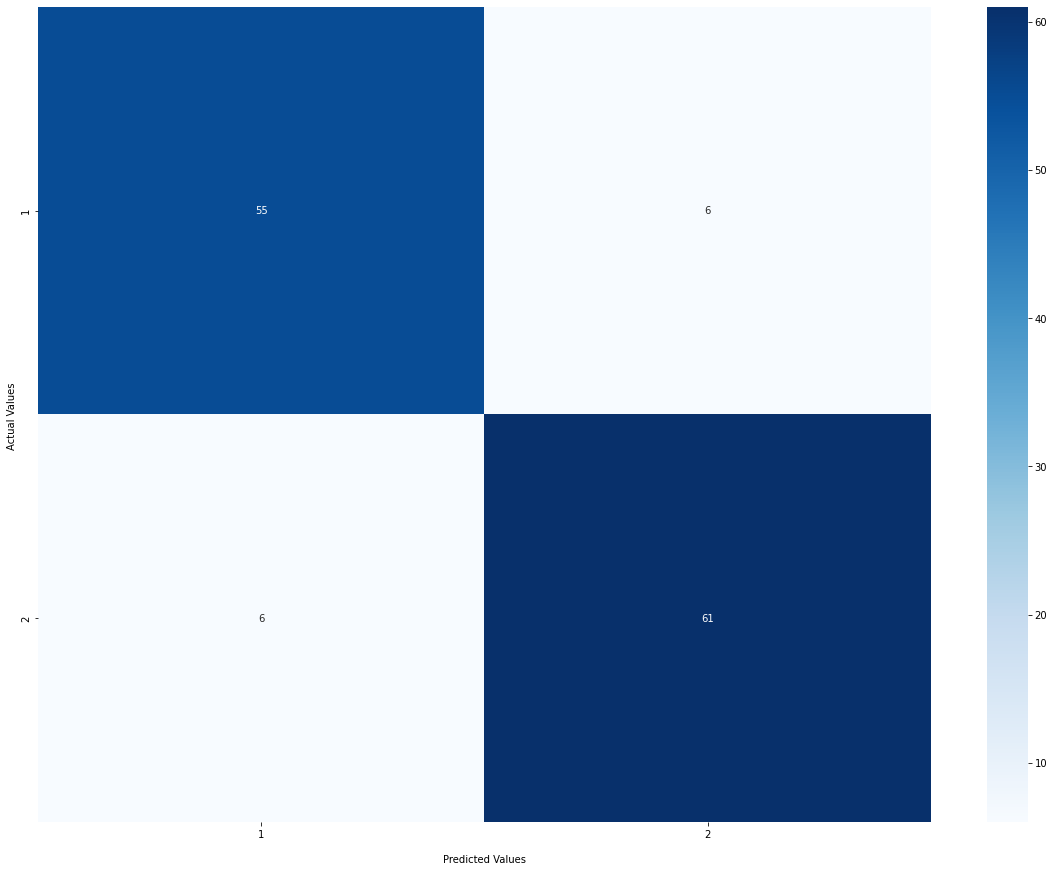

In [340]:
from sklearn.metrics import confusion_matrix

X_test, y_true = next(iter(test_dataloader))
y_pred = model(X_test).argmax(dim=1)

cm = confusion_matrix(y_true, y_pred)

import seaborn as sns

plt.rcParams["figure.figsize"] = (20, 15)

ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(labeler.classes_)
ax.yaxis.set_ticklabels(labeler.classes_)

plt.show()

In [341]:
torch.save(model, 'review_model.pth')

In [343]:
# 3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)

# model = torch.load('review_model.pth')
# model.eval()

test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.295814 



In [344]:
# 2 - хорошо, 1 - плохо 
review = "The most awful place i've ever been."
review = preprocess_text(review)
x = train_dataset.vectorize(review)
predictions = model(x)
print(predictions, labeler.inverse_transform([predictions.argmax()]))

tensor([ 2.0079, -2.0866], grad_fn=<AddBackward0>) [1]


In [345]:
review = "The best place i've ever been. I would recommed ot to all my friends"
review = preprocess_text(review)
x = train_dataset.vectorize(review)
predictions = model(x)
print(predictions, labeler.inverse_transform([predictions.argmax()]))

tensor([-1.4329,  1.5008], grad_fn=<AddBackward0>) [2]
